# BigGAN + CLIP + CMA-ES

Based on [j.mp/wanderclip](https://j.mp/wanderclip) by Eyal Gruss [@eyaler](https://twitter.com/eyaler) [eyalgruss.com](https://eyalgruss.com)

Modified to run on nautilus.optiputer.net/z8 by robert.twomey@gmail.com

# Start Here, Then Run All

Results show up in `/work/results/` in the file browser at left

In [17]:
prompts = [
    "Midway on our life's journey, I found myself",
    "In dark woods, the right road lost",
    "To tell About those woods is hard - so tangled and rough",
    "And savage that thinking of it now, I feel",
    "The old fear stirring: death is hardly more bitter.",
    "And yet, to treat the good I found there as well",
    "I'll tell what I saw, though how I came to enter",
    "I cannot well say, being so full of sleep",
    "Whatever moment it was I began to blunder",
    "Off the true path. But when I came to stop",
    "Below a hill that marked one end of the valley",
    "That had pierced my heart with terror, I looked up",
    "Toward the crest and saw its shoulders already",
    "Mantled in rays of that bright planet that shows",
    "The road to everyone, whatever our journey.",
    "Then I could feel the terror begin to ease",
    "That churned in my heart's lake all through the night.",
    "As one still panting, ashore from dangerous seas",
    "Looks back at the deep he has escaped, my thought",
    "Returned, still fleeing, to regard that grim defile", 
    "That never left any alive who stayed in it."
]

seed = 9#1#3
iterations = 40#100#40

# 1. Imports to start session

## Load Models

In [1]:
from pytorch_pretrained_biggan import BigGAN
last_gen_model = 'biggan-deep-512'
biggan_model = BigGAN.from_pretrained(last_gen_model).cuda().eval()

%cd CLIP
import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)

import nltk
nltk.download('wordnet')

100%|██████████| 800/800 [00:00<00:00, 345815.03B/s]


/home/jovyan/work/visual-imagination/CLIP


100%|███████████████████████████████████████| 354M/354M [00:12<00:00, 28.9MiB/s]
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Generation Settings

1. For **prompt** OpenAI suggest to use the template "A photo of a X." or "A photo of a X, a type of Y." [[paper]](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)
2. For **initial_class** you can either use free text or select a special option from the drop-down list.
3. Free text and 'From prompt' might fail to find an appropriate ImageNet class.
4. **seed**=0 means no seed.

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import sys
import imageio
from IPython.display import HTML, Image, clear_output
from scipy.stats import truncnorm, dirichlet
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils
from nltk.corpus import wordnet as wn
#from base64 import b64encode
from time import time
import datetime

In [3]:
# make a fresh output directory
outpath = "/home/jovyan/work/output/"
resultspath = "/home/jovyan/work/results/"
!rm -rf $outpath
!mkdir -p $outpath
!mkdir -p $resultspath

In [4]:
prompt = 'That never left any alive who stayed in it.'

In [5]:
#@title Generate!
gen_model = 'biggan-deep' #@param ['biggan-deep', 'sigmoid']
size = '512' #@param [512, 256, 128] 
color = True #@param {type:'boolean'}
initial_class = 'Random mix' #@param ['From prompt', 'Random class', 'Random Dirichlet', 'Random mix', 'Random embeddings'] {allow-input: true}
optimize_class = True #@param {type:'boolean'}
class_smoothing = 0.1 #@param {type:'number'}
truncation = 1 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES + SGD interleaved','CMA-ES + Adam interleaved','CMA-ES + terminal SGD','CMA-ES + terminal Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50','RN101','RN50x4']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
noise_normality_loss =  0#@param {type:'number'}
embed_normality_loss = 0 #@param {type:'number'}
minimum_entropy_loss = 0.0001 #@param {type:'number'}
total_variation_loss = 0.1 #@param {type:'number'}
iterations = 100 #@param {type:'integer'}
terminal_iterations = 100 #@param {type:'integer'}
show_every = 1 #@param {type:'integer'}
save_every = 1 #@param {type:'integer'}
fps = 1 #@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}
seed =  1#@param {type:'number'}

softmax_temp = 1
emb_factor = 0.067 #calculated empirically 
loss_factor = 100
sigma0 = 0.5 #http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
cma_adapt = True
cma_diag = 'sigmoid' in gen_model
cma_active = True
cma_elitist = False
noise_size = 128
class_size = 128 if initial_class.lower()=='random embeddings' else 1000
channels = 3 if color else 1

In [6]:
# seeding
if seed == 0:
    seed = None
    state = None
else:
    # torch.manual_seed(np.random.randint(sys.maxsize))
    state = np.random.RandomState(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

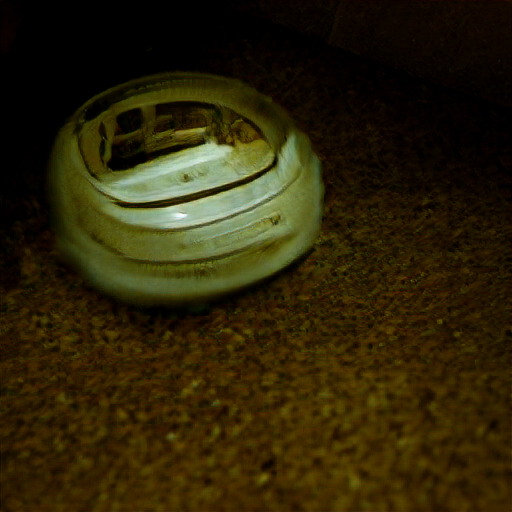

sample=99 iter=99 best: total=70.24 cos=70.19 reg=0.052 avg: total=71.72 cos=71.67 reg=0.051 std: total=0.77 cos=0.77 reg=0.001 noise: avg=0.15 std=1.431 1st=shield(0.06) 2nd=punching_bag(0.01) 3rd=tailed_frog(0.01) components: >=0.5:0, >=0.3:0, >=0.1:0
Best index: 6
took: 355 secs (3.56 sec/iter) on GPU 0: Quadro RTX 8000 (UUID: GPU-08ebd3a8-80f9-449f-8dbf-6f28a0ddaf65). 
CUDA memory: 1.2 GB
prompt: That never left any alive who stayed in it.


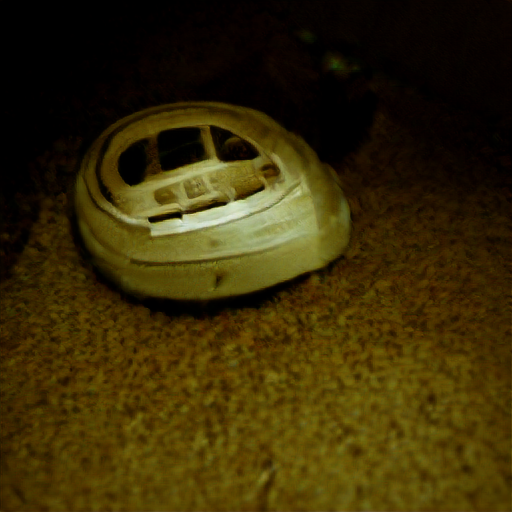

best_loss=70.11 best_iter=93


In [7]:
gen_model = gen_model + '-' + size
if gen_model != last_gen_model and 'biggan' in gen_model:
  biggan_model = BigGAN.from_pretrained(gen_model).cuda().eval()
  last_gen_model = gen_model
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model
clip_res = perceptor.input_resolution.item()
sideX = sideY = int(size)
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1
if 'CMA' not in optimizer:
  pop_size = 1
if 'biggan' not in gen_model:
  optimize_class = False
requires_grad = ('SGD' in optimizer or 'Adam' in optimizer) and ('terminal' not in optimizer or terminal_iterations>0)
total_iterations = iterations + terminal_iterations*('terminal' in optimizer)

def my_forward(self, z, class_label, truncation):
  assert 0 < truncation <= 1

  if initial_class.lower()=='random embeddings':
    embed = class_label
  else:
    embed = self.embeddings(class_label)
    
  cond_vector = torch.cat((z, embed), dim=1)

  z = self.generator(cond_vector, truncation)
  return z
BigGAN.forward = my_forward

import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

def replace_to_inplace_relu(model): #saves memory; from https://github.com/minyoungg/pix2latent/blob/master/pix2latent/model/biggan.py
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.ReLU(inplace=False))
        else:
            replace_to_inplace_relu(child)
    return
replace_to_inplace_relu(biggan_model)
replace_to_inplace_relu(perceptor)

ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

def save(out,name=None):
  with torch.no_grad():
    out = out.cpu().numpy()
  img = convert_to_images(out)[0]
  if name:
    imageio.imwrite(name, np.asarray(img))
  return img

def save_vec(out,name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

def save_all_vecs(out, name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

hist = []
def checkin(i, best_ind, total_losses, losses, regs, out, noise=None, emb=None, probs=None):
  global sample_num, hist
  name = None
  if save_every and i%save_every==0:
    name = '%s/frame_%05d.jpg'%(outpath, sample_num)
  pil_image = save(out, name)
  vals0 = [sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs)]
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%tuple(vals0)
  vals1 = []
  if noise is not None:
    vals1 = [np.mean(noise), np.std(noise)]
    stats += ' noise: avg=%.2f std=%.3f'%tuple(vals1)
  vals2 = []
  if emb is not None:
    vals2 = [emb.mean(),emb.std()]
    stats += ' emb: avg=%.2f std=%.3f'%tuple(vals2)
  elif probs:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    vals2 = [ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size]
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%tuple(vals2)
  hist.append(vals0+vals1+vals2)
  if show_every and i%show_every==0:
    clear_output()
    display(pil_image)  
  print(stats)
  print('Best index: %s' % best_ind)
  # save best vectors
  save_vec(noise_vector[best_ind], outpath+'noise_%05d.txt'%sample_num) # saves the first vectors
  save_vec(class_vector[best_ind], outpath+'class_%05d.txt'%sample_num)  
  sample_num += 1

eps = 1e-8
class_vector = None
if 'sigmoid' in gen_model:
  noise_size = channels*sideY*sideX
  noise_vector = np.random.rand(pop_size, noise_size).astype(np.float32)
  noise_vector = np.log((noise_vector+eps)/(1-noise_vector+eps))
else:
  noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214

  if initial_class.lower() == 'random class':
    class_vector = np.ones(shape=(pop_size, class_size), dtype=np.float32)*class_smoothing/999
    class_vector[0,np.random.randint(class_size)] = 1-class_smoothing
  elif initial_class.lower() == 'random dirichlet':
    class_vector = dirichlet.rvs([pop_size/class_size] * class_size, size=1, random_state=state).astype(np.float32)
  elif initial_class.lower() == 'random mix':
    class_vector = np.random.rand(pop_size, class_size).astype(np.float32)
  elif initial_class.lower() == 'random embeddings':
    class_vector = np.random.randn(pop_size, class_size).astype(np.float32)
  else:
    if initial_class.lower() == 'from prompt':
      initial_class = prompt
    try:
      class_vector = None
      class_vector = one_hot_from_names(initial_class, batch_size=pop_size)
      assert class_vector is not None
      class_vector = class_vector*(1-class_smoothing*class_size/(class_size-1))+class_smoothing/(class_size-1)
    except Exception as e:  
      print('Error: could not find initial_class. Try something else.')
      raise e

  if initial_class.lower() != 'random embeddings':
    class_vector = class_vector/np.sum(class_vector,axis=-1, keepdims=True)
    class_vector = np.log(class_vector+eps)-np.mean(np.log(class_vector+eps),axis=-1, keepdims=True)
  initial_class_vector = class_vector[0]
  if initial_class.lower() in ('random mix','random embeddings'):
    initial_class_vector = initial_class_vector*0
  class_vector = torch.tensor(class_vector, requires_grad=requires_grad, device='cuda')
  smoothed_ent = -torch.tensor(class_smoothing*np.log(class_smoothing/999+eps)+(1-class_smoothing)*np.log(1-class_smoothing+eps), dtype=torch.float32).cuda()
noise_vector = torch.tensor(noise_vector, requires_grad=requires_grad, device='cuda')

if requires_grad:
  params = [noise_vector]
  if optimize_class:
    params = params + [class_vector]
  if 'SGD' in optimizer:
    optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
  else:
    optim = torch.optim.Adam(params, lr=learning_rate)

tx = clip.tokenize(prompt)
with torch.no_grad():
  target_clip = perceptor.encode_text(tx.cuda())

def get_output(noise_vector, class_vector):
  save_class_vector_norm = None
  if 'sigmoid' in gen_model:
    out = noise_vector.sigmoid().reshape(1, channels, sideY, sideX)*2-1
  else:
    if stochastic_truncation: #https://arxiv.org/abs/1702.04782
      with torch.no_grad():
        trunc_indices = noise_vector.abs() > 2*truncation
        size = torch.count_nonzero(trunc_indices).cpu().numpy()
        trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
        noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad=requires_grad, device='cuda')
    else:
      noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
    if initial_class.lower() == 'random embeddings':
      class_vector_norm = class_vector*emb_factor
    else:
      class_vector_norm = torch.softmax(class_vector/softmax_temp,dim=-1)
    out = biggan_model(noise_vector, class_vector_norm, truncation)
    if channels==1:
      out = out.mean(dim=1, keepdim=True)
    if initial_class.lower() != 'random embeddings':
      save_class_vector_norm = class_vector_norm
  if channels==1:
    out = out.repeat(1,3,1,1)
  return out, save_class_vector_norm

def normality_loss(vec): #https://arxiv.org/abs/1903.00925
    mu2 = vec.mean().square()
    sigma2 = vec.var()
    return mu2+sigma2-torch.log(sigma2)-1

global_best_loss = np.inf
global_best_iteration = 0
global_best_noise_vector = None
global_best_class_vector = None
def ascend_txt(i, grad_step=False, show_save=False):
  global global_best_loss, global_best_iteration, global_best_noise_vector, global_best_class_vector
  prev_class_vector_norms = []
  regs = []
  losses = []
  total_losses = []
  best_loss = np.inf
  global_reg = torch.tensor(0, device='cuda', dtype=torch.float32, requires_grad=grad_step)
  if 'biggan' in gen_model:
    if optimize_class and embed_normality_loss and initial_class.lower() == 'random embeddings':
      global_reg = global_reg+embed_normality_loss*normality_loss(class_vector)
    if noise_normality_loss:
      global_reg = global_reg+noise_normality_loss*normality_loss(noise_vector)
    global_reg = loss_factor*global_reg  
    if grad_step:
      global_reg.backward()
  for j in range(pop_size):
    p_s = []
    out, class_vector_norm = get_output(noise_vector[j:j+1], None if class_vector is None else class_vector[j:j+1])
    if class_vector_norm is not None:
      with torch.no_grad():
        prev_class_vector_norms.append(class_vector_norm.cpu().numpy()[0])
    
    for aug in range(augmentations):
      if sideX<=clip_res and sideY<=clip_res or augmentations==1:
        apper = out  
      else:
        size = torch.randint(int(.7*sideX), int(.98*sideX), ())
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
      apper = (apper+1)/2
      apper = nn.functional.interpolate(apper, clip_res, mode='bilinear')
      #apper = apper.clamp(0,1)
      p_s.append(apper)
    into = nom(torch.cat(p_s, 0))
    predict_clip = perceptor.encode_image(into)
    loss = loss_factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
    total_loss = loss
    regs.append(global_reg.item())
    if 'sigmoid' in gen_model and total_variation_loss or 'biggan' in gen_model and optimize_class and minimum_entropy_loss and initial_class.lower() != 'random embeddings':
      if 'sigmoid' in gen_model and total_variation_loss:
        reg = total_variation_loss*((out[:, :, :-1, :] - out[:, :, 1:, :]).abs().mean() + (out[:, :, :, :-1] - out[:, :, :, 1:]).abs().mean())
      elif 'biggan' in gen_model and optimize_class and minimum_entropy_loss and initial_class.lower() != 'random embeddings':
        reg = minimum_entropy_loss*((-class_vector_norm*torch.log(class_vector_norm+eps)).sum()-smoothed_ent).abs()
      reg = loss_factor*reg
      total_loss = total_loss + reg
      with torch.no_grad():
        regs[-1] += reg.item()
    with torch.no_grad():
      losses.append(loss.item())
      total_losses.append(total_loss.item()+global_reg.item())
    if total_losses[-1]<best_loss:
      best_loss = total_losses[-1]
      best_ind = j
      best_out = out
      if best_loss < global_best_loss:
        global_best_loss = best_loss
        global_best_iteration = i
        with torch.no_grad():
          global_best_noise_vector = noise_vector[best_ind]
          if class_vector is not None:
            global_best_class_vector = class_vector[best_ind]

    if grad_step:    
      total_loss.backward()

  if grad_step:
    optim.step()
    optim.zero_grad()

  if show_save and (save_every and i % save_every == 0 or show_every and i % show_every == 0):
    noise = None
    emb = None
    if 'biggan' in gen_model:
      with torch.no_grad():
        noise = noise_vector.cpu().numpy()
        if initial_class.lower() == 'random embeddings':
          emb = class_vector.cpu().numpy()
    checkin(i, best_ind, total_losses, losses, regs, best_out, noise, emb, prev_class_vector_norms)  
  return total_losses, best_ind

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
if 'CMA' in optimizer:
  initial_vector = np.zeros(noise_size)
  bounds = None
  #if 'biggan' in gen_model and not stochastic_truncation:
  #  bounds = [-2*truncation*np.ones(noise_size),2*truncation*np.ones(noise_size)]
  if optimize_class:
    initial_vector = np.hstack([initial_vector, initial_class_vector])
    #if not stochastic_truncation:
    #  bounds[0] = list(bounds[0]) + [None]*class_size
    #  bounds[1] = list(bounds[1]) + [None]*class_size
  cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': cma_adapt, 'CMA_diagonal': cma_diag, 'CMA_active': cma_active, 'CMA_elitist':cma_elitist, 'bounds':bounds}
  cmaes = cma.CMAEvolutionStrategy(initial_vector, sigma0, inopts=cma_opts)

sample_num = 0
machine = !nvidia-smi -L
start = time()
for i in range(total_iterations):    
  if 'CMA' in optimizer and i<iterations:
    with torch.no_grad():
      cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
      if optimize_class:
        noise_vector.data, class_vector.data = torch.split_with_sizes(cma_results, (noise_size, class_size), dim=-1)
        class_vector.data = class_vector.data
      else:
        noise_vector.data = cma_results      
  if requires_grad and ('terminal' not in optimizer or i>=iterations):
    losses, best_ind = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer or i>=iterations)
    assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
  if 'CMA' in optimizer and i<iterations:
    with torch.no_grad():
      losses, best_ind = ascend_txt(i, show_save=True)
      if i<iterations-1:
        if optimize_class:
          vectors = torch.cat([noise_vector,class_vector], dim=1)
        else:
          vectors = noise_vector
        cmaes.tell(vectors.cpu().numpy(), losses)
      elif 'terminal' in optimizer and terminal_iterations:
        pop_size = 1
        noise_vector[0] = global_best_noise_vector
        if class_vector is not None:
          class_vector[0] = global_best_class_vector
  if save_every and i % save_every == 0 or show_every and i % show_every == 0:
    print('took: %d secs (%.2f sec/iter) on %s. \nCUDA memory: %.1f GB'%(time()-start,(time()-start)/(i+1), machine[0], torch.cuda.max_memory_allocated()/1024**3))
    print('prompt: %s' % prompt)

# from modified BigCLIP
# prompt_safe = prompt.replace(" ","_")
# results_timestamp = resultspath+'%s_%s' % (prompt_safe, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
# save(best_out, results_timestamp+'.jpg')
# save_vec(noise_vector[best_ind], results_timestamp+'_noise.txt')
# save_vec(class_vector[best_ind], results_timestamp+'_class.txt')

prompt_safe = prompt.replace(" ","_")
out, _ = get_output(global_best_noise_vector.unsqueeze(0), None if global_best_class_vector is None else global_best_class_vector.unsqueeze(0))
name = '%s/%s.jpg'%(resultspath, prompt_safe)
pil_image = save(out,name)
save_vec(global_best_noise_vector, '%s/%s_noise.txt' % prompt_safe)
save_vec(global_best_class_vector, '%s/%s_class.txt' % prompt_safe)

display(pil_image)  
print('best_loss=%.2f best_iter=%d'%(global_best_loss,global_best_iteration))

# move outputs to saved path with datestampt
newdir = outpath[:-1]+"_"+prompt+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
!mv $outpath $newdir
!mkdir -p $outpath

In [10]:
# move outputs to saved path with datestamp
newdir = outpath[:-1]+"_"+prompt_safe+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
!mv $outpath $newdir
!mkdir -p $outpath

In [16]:
save_vec(global_best_noise_vector, '%s/%s_noise.txt' % (resultspath, prompt_safe))
save_vec(global_best_class_vector, '%s/%s_class.txt' % (resultspath, prompt_safe))

In [ ]:
# from google.colab import files, output
# output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')
# files.download('/content/%s.mp4'%prompt)

# Reference


Based on SIREN+CLIP Colabs by: [@advadnoun](https://twitter.com/advadnoun), [@norod78](https://twitter.com/norod78)

Using the works:

https://github.com/openai/CLIP

https://tfhub.dev/deepmind/biggan-deep-512

https://github.com/huggingface/pytorch-pretrained-BigGAN

http://www.aiartonline.com/design-2019/eyal-gruss (WanderGAN)

Other CLIP notebooks: https://www.reddit.com/r/MachineLearning/comments/ldc6oc/p_list_of_sitesprogramsprojects_that_use_openais

A curated list of more online generative tools see: [j.mp/generativetools](https://j.mp/generativetools)
